# Synthetic Experiments

This aims to be an easily runnable notebook, reporting results to sacred + omniboard + mongodb, which compares a couple set2seq methods (pure PtrNet, DeepSets+ptr, SetTransformer+ptr and Custom+ptr) on the synthetic, functional task, with **more robust metrics** regarding performance on these different structural rules we put into the catalogs.

##### Imports

In [1]:
import copy
import json
import numpy as np
import os
import pandas as pd
import random
import time

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Parameter
from torch.autograd import Variable

from matplotlib import pyplot as plt
from tqdm import tqdm

# visuals
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# sacred experiment tracking with omniboard
from sacred import Experiment
from sacred.observers import MongoObserver

In [3]:
# custom utils
from synthetic_functional import *
from utils import count_params, train_epochs
from data import test_model_custom, compare_solved_sort_unique, \
    get_single_kendall_tau, get_single_spearman_rho, get_batch_rank_correlation, get_batch_rank_correlation_and_perc_valid

In [4]:
# reload if saved changes in modules
%load_ext autoreload
%autoreload 2

In [5]:
# base img path
path_visuals = os.path.join(os.getcwd(), 'img')

r = os.path.join(path_visuals, 'red_offer.png')
b = os.path.join(path_visuals, 'blue_offer.png')
y = os.path.join(path_visuals, 'yellow_offer.png')
g = os.path.join(path_visuals, 'green_offer.png')
p = os.path.join(path_visuals, 'purple_offer.png')

pb = os.path.join(path_visuals, 'page_break.png')
cs = os.path.join(path_visuals, 'catalog_start.png')
ce = os.path.join(path_visuals, 'catalog_end.png')

# map human-readable catalog elem names to img paths
img_path_map = dict(r=r, b=b, y=y, g=g, p=p,
                    page_break=pb, catalog_start=cs, catalog_end=ce)

In [6]:
img_path_map_ind = {1:r, 0:b, 2:y, 3:g, 4:p,
                        6:pb, 5:cs, 7:ce}

## Config

In [7]:
config = dict()

In [8]:
# sacred experiment
config['ptr_mask'] = True
config['task'] = 'set_to_sequence_functional_synthetic'
config['experiment_name'] = config['task'] + '_mask_' + str(config['ptr_mask'])
config['db_name'] = 'sacred'
config['db_url'] = 'localhost:27017'

In [9]:
# dataset
config['n_catalogs'] = 50000
config['n_mset_shuffles'] = 1
config['train_proportion'] = 0.8
config['n_tokens'] = 16
config['n_offers'] = 12
config['max_pages'] = 6
config['min_pages'] = 3
config['offer_distributions'] = {
    'b': 100,
    'r': 100,
    'y': 100,
    'g': 10,
    'p': 5}
config['word2idx'] = {'b': 0, 'r': 1, 'y': 2, 'g': 3, 'p': 4, 'catalog_start': 5, 'page_break': 6, 'catalog_end': 7}
config['idx2word'] = {v: k for k, v in config['word2idx'].items()}
config['dataset_path'] = os.path.join(os.getcwd(), 'data', '{}_c{}'.format(
    config['task'],
    config['n_catalogs']))
config['dataset_name'] = '{}_c{}_ntok{}_noff{}'.format(
    config['task'],
    config['n_catalogs'],
    config['n_tokens'],
    config['n_offers'])

# paths
path_to_dataset_train = os.path.join(config['dataset_path'], 'train.pb')
path_to_dataset_cv =  os.path.join(config['dataset_path'], 'cv.pb')
path_to_dataset_test = os.path.join(config['dataset_path'], 'test.pb')

In [10]:
# training
config['batch_size'] = 64
config['learning_rate'] =  0.0001
config['num_epochs'] = 20 # needs to be much higher for full experiments

In [11]:
# model
config['ptr_elem_dim'] = 1
config['ptr_emb_dim'] = 128
config['ptr_hid_dim'] = 128
config['ptr_lstm_lay'] = 2
config['ptr_lstm_lay_plus_for_ptrnet_raw'] = 5
config['ptr_dropout'] = 0.05
config['ptr_bidir'] = True

### Structural Rules

#### Structural Rules Description

This set of rules includes pairwise and higher-order interactions between offers. E.g. the presence of a (G)reen changes the interaction between (R) and (Y), and the presence of both (G) and (P) simultaneously changes the entire output sequence order (rules for start and end page).

1. Page composition rules:
    1. fully one of these colours,  **but never** fully (G)reen: 
        * (R)ed
        * (Y)ellow
        * (B)lue
        * (P)urple
    2. if there is **no (G) and no (P)** offer in the set:
        * a 50/50 mix of (R) and (Y)
    3. if there **is (G) but no (P)** in the set:
        * a 50/50 mix of (R) and **(G)**
2. Offers per page rules:
   * as specified in config, usually between 1-4, or either 2 or 4 for mixed pages to allow for the proportion.
3. Pages per catalog rules:
   * as specified, approximate due to hard same-number-of-tokens rule
4. Catalog start rules:
   1. if **no (P)** offer in the set:
       * start with full (R) page
   2. if **(P) but no (G)** offer present:
       * start with full (B) page
5. Catalog end rules:
   1. if **not (P) and not (G)** offer in the set:
       * end with full (B) page
   2. if **both (P) and (G)** offers are present:
       * end with full (P) page
6. Distributional rules:
    * as specified in config (the proportional chance of an offer being present in the input set)

In [12]:
# catalog-level rules
basic_catalog_rules = [
    {'name': 'first_page',
     'spec': 'all_red'
     },
    {'name': 'last_page',
     'spec': 'all_blue'
     },
    {'name': 'max_pages',
     'spec': config['max_pages']},
    {'name': 'min_pages',
     'spec': config['min_pages']}
]

green_only_catalog_rules = [
    {'name': 'first_page',
     'spec': 'all_red'
     },
    {'name': 'last_page',
     'spec': 'all_blue'
     },
    {'name': 'max_pages',
     'spec': config['max_pages']},
    {'name': 'min_pages',
     'spec': config['min_pages']}
]

purple_only_catalog_rules = [
    {'name': 'first_page',
     'spec': 'all_blue'
     },
    {'name': 'last_page',
     'spec': 'all_blue'
     },
    {'name': 'max_pages',
     'spec': config['max_pages']},
    {'name': 'min_pages',
     'spec': config['min_pages']}
]

purple_and_green_catalog_rules = [
    {'name': 'first_page',
     'spec': 'all_red'
     },
    {'name': 'last_page',
     'spec': 'all_purple'
     },
    {'name': 'max_pages',
     'spec': config['max_pages']},
    {'name': 'min_pages',
     'spec': config['min_pages']}
]

In [13]:
# valid section rules
basic_valid_sections = [
        {'name': 'all_red',
         'mixed': False,
         'allowed_offer_types': ['r'],
         'offers_per_section': [4, 3, 2, 1],
         },
        {'name': 'all_blue',
         'mixed': False,
         'allowed_offer_types': ['b'],
         'offers_per_section': [4, 3, 2, 1]
         },
        {'name': 'all_yellow',
         'mixed': False,
         'allowed_offer_types': ['y'],
         'offers_per_section': [4, 3, 2, 1],
         'min_offers': 1
         },
        {'name': 'mix_red_yellow',
         'mixed': True,
         'allowed_offer_types': ['r', 'y'],
         'offers_per_section': [4, 2],
         'mix_ratio': [0.5, 0.5]
         }
    ]

green_only_valid_sections = [
        {'name': 'all_red',
         'mixed': False,
         'allowed_offer_types': ['r'],
         'offers_per_section': [4, 3, 2, 1],
         },
        {'name': 'all_blue',
         'mixed': False,
         'allowed_offer_types': ['b'],
         'offers_per_section': [4, 3, 2, 1]
         },
        {'name': 'all_yellow',
         'mixed': False,
         'allowed_offer_types': ['y'],
         'offers_per_section': [4, 3, 2, 1],
         'min_offers': 1
         },
        {'name': 'mix_green_red',
         'mixed': True,
         'allowed_offer_types': ['r', 'g'],
         'offers_per_section': [4, 2],
         'mix_ratio': [0.5, 0.5]
         }
    ]

purple_only_valid_sections = [
        {'name': 'all_red',
         'mixed': False,
         'allowed_offer_types': ['r'],
         'offers_per_section': [4, 3, 2, 1],
         },
        {'name': 'all_blue',
         'mixed': False,
         'allowed_offer_types': ['b'],
         'offers_per_section': [4, 3, 2, 1]
         },
        {'name': 'all_yellow',
         'mixed': False,
         'allowed_offer_types': ['y'],
         'offers_per_section': [4, 3, 2, 1],
         'min_offers': 1
         },
        {'name': 'mix_red_yellow',
         'mixed': True,
         'allowed_offer_types': ['r', 'y'],
         'offers_per_section': [4, 2],
         'mix_ratio': [0.5, 0.5]
         },
        {'name': 'all_purple',
         'mixed': False,
         'allowed_offer_types': ['p'],
         'offers_per_section': [4, 3, 2, 1],
         }
    ]

purple_and_green_valid_sections = [
        {'name': 'all_red',
         'mixed': False,
         'allowed_offer_types': ['r'],
         'offers_per_section': [4, 3, 2, 1],
         },
        {'name': 'all_blue',
         'mixed': False,
         'allowed_offer_types': ['b'],
         'offers_per_section': [4, 3, 2, 1]
         },
        {'name': 'all_yellow',
         'mixed': False,
         'allowed_offer_types': ['y'],
         'offers_per_section': [4, 3, 2, 1],
         'min_offers': 1
         },
        {'name': 'mix_red_yellow',
         'mixed': True,
         'allowed_offer_types': ['r', 'y'],
         'offers_per_section': [4, 2],
         'mix_ratio': [0.5, 0.5]
         },
        {'name': 'all_purple',
         'mixed': False,
         'allowed_offer_types': ['p'],
         'offers_per_section': [4, 3, 2, 1],
         },
        {'name': 'mix_green_red',
         'mixed': True,
         'allowed_offer_types': ['r', 'g'],
         'offers_per_section': [4, 2],
         'mix_ratio': [0.5, 0.5]
         }
    ]

In [14]:
# full rules, jointly
rules = {'basic':
                 {'catalog_rules': basic_catalog_rules,
                  'valid_sections': basic_valid_sections},
             'green_only':
                 {'catalog_rules': green_only_catalog_rules,
                  'valid_sections': green_only_valid_sections},
             'purple_only':
                 {'catalog_rules': purple_only_catalog_rules,
                  'valid_sections': purple_only_valid_sections},
             'purple_and_green':
                 {'catalog_rules': purple_and_green_catalog_rules,
                  'valid_sections': purple_and_green_valid_sections}
             }

In [15]:
config['rules'] = rules

In [16]:
config

{'ptr_mask': True,
 'task': 'set_to_sequence_functional_synthetic',
 'experiment_name': 'set_to_sequence_functional_synthetic_mask_True',
 'db_name': 'sacred',
 'db_url': 'localhost:27017',
 'n_catalogs': 50000,
 'n_mset_shuffles': 1,
 'train_proportion': 0.8,
 'n_tokens': 16,
 'n_offers': 12,
 'max_pages': 6,
 'min_pages': 3,
 'offer_distributions': {'b': 100, 'r': 100, 'y': 100, 'g': 10, 'p': 5},
 'word2idx': {'b': 0,
  'r': 1,
  'y': 2,
  'g': 3,
  'p': 4,
  'catalog_start': 5,
  'page_break': 6,
  'catalog_end': 7},
 'idx2word': {0: 'b',
  1: 'r',
  2: 'y',
  3: 'g',
  4: 'p',
  5: 'catalog_start',
  6: 'page_break',
  7: 'catalog_end'},
 'dataset_path': '/home/paperspace/procat/data/set_to_sequence_functional_synthetic_c50000',
 'dataset_name': 'set_to_sequence_functional_synthetic_c50000_ntok16_noff12',
 'batch_size': 64,
 'learning_rate': 0.0001,
 'num_epochs': 20,
 'ptr_elem_dim': 1,
 'ptr_emb_dim': 128,
 'ptr_hid_dim': 128,
 'ptr_lstm_lay': 2,
 'ptr_lstm_lay_plus_for_ptrnet_ra

### Experiment Tracking via Sacred

In [17]:
# initiate the experiment
ex = Experiment(name=config['experiment_name'], interactive=True)

# add an observer, storing experiment info
ex.observers.append(MongoObserver(url=config['db_url'], db_name=config['db_name']))

In [18]:
# experiment config
@ex.config
def ex_config():
    
    # general
    learning_rate = config['learning_rate']
    dataset = config['dataset_name'] 
    epochs = config['num_epochs']
    cfg = config
    
    # model
    model = None
    final_training_loss = None
    optimizer = None
    
    # db 
    db_name = config['db_name']
    db_url = config['db_url']

In [19]:
# experiment run function
@ex.main
def run_model_tests():

    # run all tests, get all results
    result_general, result_tau, result_spearman, rank_valid_perc, catalogs_testable, catalogs_corrent_n_tokens,\
           catalogs_num_offers_match, valid_sections_avg, \
           valid_sections_avg_basic, valid_sections_avg_green_only,\
           valid_sections_avg_purple_only, valid_sections_avg_purple_and_green, \
           valid_struture_avg, valid_struture_avg_basic, \
           valid_struture_avg_green_only, valid_struture_avg_purple_only, \
           valid_struture_avg_purple_and_green = run_tests(current_tested_model, test_dataloader, config)
    
    # log params and results
    log_experiment_results(result_general, result_tau, result_spearman, rank_valid_perc,
                           catalogs_testable, catalogs_corrent_n_tokens,
                           catalogs_num_offers_match, valid_sections_avg,
                           valid_sections_avg_basic, valid_sections_avg_green_only, 
                           valid_sections_avg_purple_only, valid_sections_avg_purple_and_green, 
                           valid_struture_avg, valid_struture_avg_basic, 
                           valid_struture_avg_green_only, valid_struture_avg_purple_only, 
                           valid_struture_avg_purple_and_green)
    
    return round(result_general, 5)

In [20]:
def run_tests(a_model, a_dataloader, a_config):
    
    print('Model: ', a_model.__class__)

    a_model.eval() 
    
    # general accuracy
    result_general, _ = test_model_custom(a_model, a_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
    print('Result: {:.4f}'.format(result_general))
    
    # functional metrics
    catalogs_testable, catalogs_corrent_n_tokens,\
           catalogs_num_offers_match, valid_sections_avg, \
           valid_sections_avg_basic, valid_sections_avg_green_only,\
           valid_sections_avg_purple_only, valid_sections_avg_purple_and_green, \
           valid_struture_avg, valid_struture_avg_basic, \
           valid_struture_avg_green_only, valid_struture_avg_purple_only, \
           valid_struture_avg_purple_and_green = test_model_functional(a_model, a_dataloader, a_config)

    
    result_tau, rank_valid_perc = get_batch_rank_correlation_and_perc_valid(a_dataloader, a_model, get_single_kendall_tau, print_every=999999)
    print('K-Tau: {:.4f}, perc_valid: {}'.format(result_tau, rank_valid_perc))

    result_spearman, rank_valid_perc = get_batch_rank_correlation_and_perc_valid(a_dataloader, a_model, get_single_spearman_rho, print_every=999999)
    print('S-Rho: {:.4f}, perc_valid: {}'.format(result_spearman, rank_valid_perc))

    a_model.train()
    
    return result_general, result_tau, result_spearman, rank_valid_perc, catalogs_testable, catalogs_corrent_n_tokens,\
           catalogs_num_offers_match, valid_sections_avg, \
           valid_sections_avg_basic, valid_sections_avg_green_only,\
           valid_sections_avg_purple_only, valid_sections_avg_purple_and_green, \
           valid_struture_avg, valid_struture_avg_basic, \
           valid_struture_avg_green_only, valid_struture_avg_purple_only, \
           valid_struture_avg_purple_and_green

In [21]:
def log_experiment_results(r_general, r_tau, r_spearman, rank_valid_perc, catalogs_testable, catalogs_corrent_n_tokens,
                           catalogs_num_offers_match, valid_sections_avg, valid_sections_avg_basic, valid_sections_avg_green_only, 
                           valid_sections_avg_purple_only, valid_sections_avg_purple_and_green, valid_struture_avg, valid_struture_avg_basic,
                           valid_struture_avg_green_only, valid_struture_avg_purple_only, valid_struture_avg_purple_and_green):
    
    # round if not none
    if r_tau:
        r_tau = round(r_tau, 5)
    if r_spearman:
        r_spearman = round(r_spearman, 5)
    
    # log the results
    ex.log_scalar('test.general', r_general)
    ex.log_scalar('test.rank_correlation_valid_perc', rank_valid_perc)
    ex.log_scalar('test.tau', r_tau, 5)
    ex.log_scalar('test.rho', r_spearman, 5)
    
    # general
    ex.log_scalar('test.gen_c_testable', catalogs_testable)
    ex.log_scalar('test.gen_c_corr_n_tokens', catalogs_corrent_n_tokens)
    ex.log_scalar('test.gen_c_num_off_match', catalogs_num_offers_match)
    
    # sections
    ex.log_scalar('test.sec_valid_s_avg', valid_sections_avg)
    ex.log_scalar('test.sec_valid_basic', valid_sections_avg_basic)
    ex.log_scalar('test.sec_valid_green', valid_sections_avg_green_only)
    ex.log_scalar('test.sec_valid_purple', valid_sections_avg_purple_only)
    ex.log_scalar('test.sec_valid_p_and_g', valid_sections_avg_purple_and_green)
    
    # structural
    ex.log_scalar('test.struct_valid_avg', valid_struture_avg)
    ex.log_scalar('test.struct_avg_basic', valid_struture_avg_basic)
    ex.log_scalar('test.struct_avg_green', valid_struture_avg_green_only)
    ex.log_scalar('test.struct_avg_purple', valid_struture_avg_purple_only)
    ex.log_scalar('test.struct_avg_p_and_g', valid_struture_avg_purple_and_green)

In [22]:
def test_model_functional(model, dataloader, a_config):
    
    # predict all catalogs from dataloader
    predicted_catalogs_as_indices = predict_catalogs_as_indices(dataloader, model)
    predicted_catalogs_as_raw = from_indices_to_raw(predicted_catalogs_as_indices, a_config)
    predicted_catalogs_as_instances = instantiate_catalogs(predicted_catalogs_as_raw, a_config)
    
    # get structural / functional metrics
    metrics = get_rule_metrics(predicted_catalogs_as_indices, a_config['rules'], a_config)
    
    # show
    show_metrics(metrics)

    # return unpacked
    # this has to be hardcoded for now
    
    # general
    catalogs_testable = metrics['valid_catalogs_%']
    catalogs_corrent_n_tokens = metrics['correct_n_tokens_%']
    catalogs_num_offers_match = metrics['num_offers_match_config_%']
    
    # sections
    valid_sections_avg = metrics['valid_sections_%_avg']
    valid_sections_avg_basic = metrics['valid_sections_%_per_ruleset']['basic']
    valid_sections_avg_green_only = metrics['valid_sections_%_per_ruleset']['green_only']
    valid_sections_avg_purple_only = metrics['valid_sections_%_per_ruleset']['purple_only']
    valid_sections_avg_purple_and_green = metrics['valid_sections_%_per_ruleset']['purple_and_green']
    
    # structure
    valid_struture_avg = metrics['valid_structure_%_total']
    valid_struture_avg_basic = metrics['valid_structure_%_per_ruleset']['basic']
    valid_struture_avg_green_only = metrics['valid_structure_%_per_ruleset']['green_only']
    valid_struture_avg_purple_only = metrics['valid_structure_%_per_ruleset']['purple_only']
    valid_struture_avg_purple_and_green = metrics['valid_structure_%_per_ruleset']['purple_and_green']
    
    return catalogs_testable, catalogs_corrent_n_tokens,\
           catalogs_num_offers_match, valid_sections_avg, \
           valid_sections_avg_basic, valid_sections_avg_green_only,\
           valid_sections_avg_purple_only, valid_sections_avg_purple_and_green, \
           valid_struture_avg, valid_struture_avg_basic, \
           valid_struture_avg_green_only, valid_struture_avg_purple_only, \
           valid_struture_avg_purple_and_green

## Data
Look into the available data and transform it to our needs.

### Data Generation
Create catalogs following the config and specified rules (from above).

In [23]:
# generate the raw catalogs
catalogs_raw = generate_from_rules(rules, config, debug=False)

In [24]:
# optionally throw out catalogs that didn't match target n tokens from config
catalogs_raw = discard_catalogs_with_wrong_n_tokens(catalogs_raw, config)

In [25]:
# report stats
stats = report_catalog_stats(catalogs_raw, config)

Total offer counts:  {'b': 99411, 'r': 120005, 'y': 93208, 'g': 17116, 'p': 9094}
Total offer %:  {'b': 29.34, 'r': 35.42, 'y': 27.51, 'g': 5.05, 'p': 2.68}
Average offers per catalog: 11.21
Standard Dev offers per catalog: 0.47
Catalogs per num offers:  {11: 40827, 12: 7792, 13: 1381}
Catalogs per offer type:  {'b': 49699, 'r': 49511, 'y': 47537, 'g': 15745, 'p': 8715}
Catalogs per offer type %:  {'b': 99.4, 'r': 99.02, 'y': 95.07, 'g': 31.49, 'p': 17.43, 'p_and_g': 5.07}
Catalogs per number of sections: {4: 1381, 5: 7792, 6: 40827}
Catalogs per number of sections %: {4: 2.76, 5: 15.58, 6: 81.65}
Section count by number of offers: {1: 123855, 2: 95008, 3: 35649, 4: 34934}
Section % by number of offers: {1: 42.79, 2: 32.82, 3: 12.32, 4: 12.07}


In [26]:
# instantiate class objects
catalogs_instantiated = instantiate_catalogs(catalogs_raw, config)

In [27]:
# turn to indices
catalogs_as_indices = [c.as_indices() for c in catalogs_instantiated]
print(catalogs_as_indices[0])

[5, 1, 6, 1, 2, 1, 2, 6, 0, 6, 2, 2, 6, 1, 6, 0, 0, 7]


In [28]:
# show metrics (we expect 100%)
metrics = get_rule_metrics(catalogs_as_indices, rules, config)
show_metrics(metrics)

*** METRICS ***
                                GENERAL:
              Total testable catalogs %:      100.0%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.58%

                               SECTIONS:
                Valid section average %:      99.91%
           Valid section per ruleset % :
                                        basic      99.88%
                                   green_only      100.0%
                                  purple_only      99.84%
                             purple_and_green      99.93%

                             STRUCTURAL:
              Valid catalog structure %:       99.9%
            Valid catalog % per ruleset:
                                        basic      100.0%
                                   green_only      100.0%
                                  purple_only      99.21%
                             purple_and_green      100.0%
           Valid catalog % per sub rule:
       

#### Visualize
Show the catalog sequence graphically.

In [29]:
random_idx = random.randint(0, len(catalogs_instantiated) - 1)

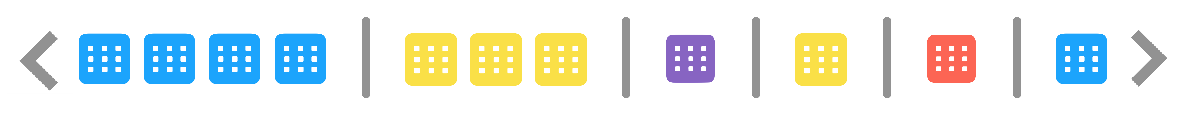

In [30]:
show_catalog(catalogs_instantiated[random_idx].as_sequence(), img_path_map)

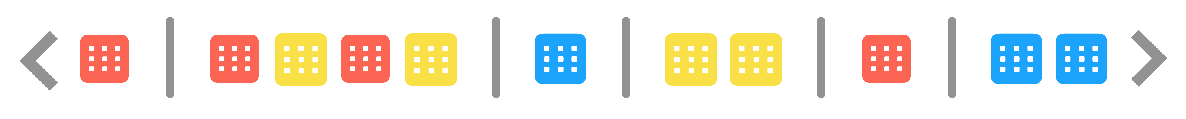

In [31]:
show_catalog(catalogs_instantiated[0].as_sequence(), img_path_map)

### Get X and Y
Now that we have our synthetic data, let's turn them into something our models will be able to understand.

In [32]:
# vectorize
X, Y = get_xy(catalogs_instantiated, config['n_mset_shuffles'])

In [33]:
# confirm
len(X)

50000

In [34]:
print(type(X[0]))

<class 'numpy.ndarray'>


Show the first one or a random one.

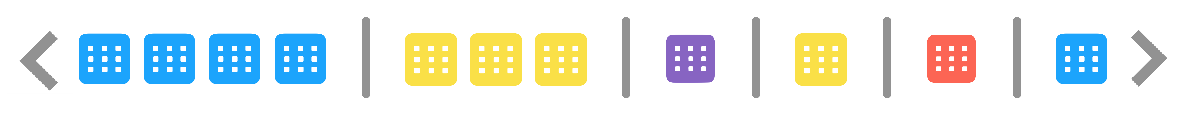

In [35]:
# show (same) random
show_restored_catalog(X[random_idx], Y[random_idx], config, img_path_map)

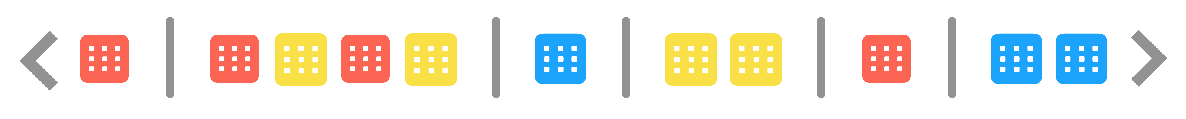

In [36]:
# show first
show_restored_catalog(X[0], Y[0], config, img_path_map)

#### Train / CV / Test split
This doesn't feel very necessary, since we're synthesizing the data according to the same exact simple distribution, but just to stay on the safe side let's do it.

In [37]:
# remind
config['train_proportion']

0.8

In [38]:
# train split
train_split_idx = int(len(X) * config['train_proportion'])
train_split_idx

40000

In [39]:
# train set
X_train = X[:train_split_idx]
Y_train = Y[:train_split_idx]
len(X_train)

40000

CV and test should be of equal length.

In [40]:
# cv / test split
validation_split_idx = int((len(X) - train_split_idx)/2)
validation_split_idx

5000

In [41]:
# cv set
X_cv = X[train_split_idx:train_split_idx + validation_split_idx]
Y_cv = Y[train_split_idx:train_split_idx + validation_split_idx]
len(X_cv)

5000

In [42]:
# test set
X_test = X[train_split_idx + validation_split_idx:]
Y_test = Y[train_split_idx + validation_split_idx:]
len(X_test)

5000

#### Torch tensors

In [43]:
# need them as torch tensors first
X_train = torch.from_numpy(np.asarray(X_train))
X_cv = torch.from_numpy(np.asarray(X_cv))
X_test = torch.from_numpy(np.asarray(X_test))

In [44]:
# now Y
Y_train = torch.from_numpy(np.asarray(Y_train))
Y_cv = torch.from_numpy(np.asarray(Y_cv))
Y_test = torch.from_numpy(np.asarray(Y_test))

In [45]:
# into datasets
dataset_train = TensorDataset(X_train, Y_train)
dataset_cv = TensorDataset(X_cv, Y_cv)
dataset_test = TensorDataset(X_test, Y_test)

In [46]:
# loader
check_dataloader = DataLoader(dataset_train, batch_size=64)

In [47]:
# check
x_batch, y_batch = next(iter(check_dataloader))
x_batch.size(), y_batch.size()

(torch.Size([64, 18]), torch.Size([64, 18]))

In [48]:
# check single
x_single = x_batch[0]
x_single

tensor([2, 1, 0, 2, 1, 6, 2, 0, 6, 7, 1, 1, 6, 0, 5, 6, 2, 6])

In [49]:
y_single = y_batch[0]
print(y_single)

tensor([14, 11,  8,  1,  6,  4,  3, 12,  7,  5, 16,  0, 15, 10, 17, 13,  2,  9])


In [50]:
x_single

tensor([2, 1, 0, 2, 1, 6, 2, 0, 6, 7, 1, 1, 6, 0, 5, 6, 2, 6])

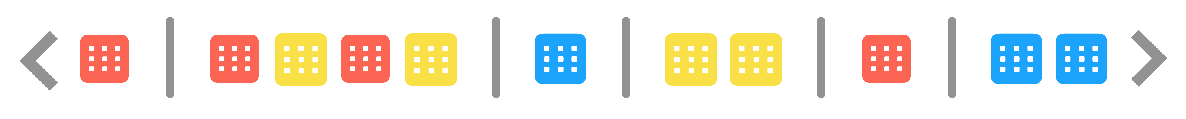

In [51]:
# confirm
show_restored_catalog(x_single, y_single, config, img_path_map)

### Persist & Reload
Another good practice - have the small dataset loaded from disk, for perfect repeatability.

In [52]:
config['dataset_path']

'/home/paperspace/procat/data/set_to_sequence_functional_synthetic_c50000'

If this directory doesn't exist, create it.

In [53]:
if os.path.isdir(config['dataset_path']):
    print('found')
else:
    os.makedirs(config['dataset_path'])
    print('directory created')

found


### Save data loaders

In [54]:
# save train
torch.save(dataset_train, path_to_dataset_train)

In [55]:
# save cv
torch.save(dataset_cv, path_to_dataset_cv)

In [56]:
# save cv
torch.save(dataset_test, path_to_dataset_test)

### Reload data loaders

In [57]:
# reload all and turn into dataloaders
train_dataset = torch.load(path_to_dataset_train)
cv_dataset = torch.load(path_to_dataset_cv)
test_dataset = torch.load(path_to_dataset_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
cv_dataloader = DataLoader(cv_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

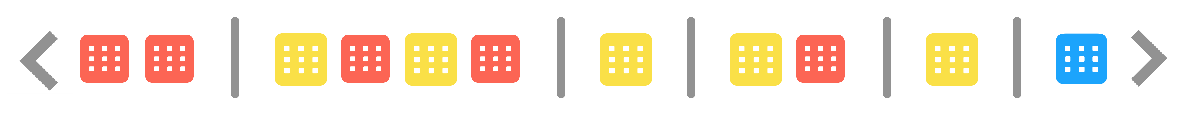

In [58]:
# confirm
x, y = get_example(train_dataloader)
show_restored_catalog(x, y, config, img_path_map)

In [59]:
type(x)

torch.Tensor

# Models

## Model PtrNet

In [60]:
from models import PointerNetwork, PointerEncoder, PointerAttention, PointerDecoder

In [61]:
# instantiate the model
model_ptrnet = PointerNetwork(
    elem_dims=config['ptr_elem_dim'], # not used if embedding_by_dict=True
    embedding_dim=config['ptr_emb_dim'],
    hidden_dim=config['ptr_hid_dim'],
    lstm_layers=config['ptr_lstm_lay']+ config['ptr_lstm_lay_plus_for_ptrnet_raw'],
    dropout=config['ptr_dropout'],
    bidir=config['ptr_bidir'],
    masking=config['ptr_mask'],
    embedding_by_dict=True,  # input is not pre-embedded, it's dictionary tokens
    embedding_by_dict_size=len(config['word2idx'])
)

In [62]:
count_params(model_ptrnet)

The model has 894,464 trainable parameters


In [63]:
# loss
CCE = torch.nn.CrossEntropyLoss()

In [64]:
# optimizer
optimizer_ptrnet = optim.Adam(
    filter(lambda p: p.requires_grad, model_ptrnet.parameters()),
    lr=config['learning_rate'])

### Model Training

In [65]:
# test untrained model
results_ptrnet, _ = test_model_custom(model_ptrnet, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_ptrnet))

Result: 0.0570


In [66]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_ptrnet, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_ptrnet, get_single_spearman_rho, print_every=999999)))

K-Tau: -0.0003, % valid: 100.0
S-Rho: 0.0011, % valid: 100.0


In [67]:
# train
last_loss_ptrnet = train_epochs(
    model_ptrnet,
    optimizer_ptrnet,
    CCE,
    train_dataloader,
    config['num_epochs'],
    allow_gpu=True,
    x_name=0,
    y_name=1)

CUDA available, using GPU:
Quadro P6000


Epoch 20 / 20: 100%|██████████| 625/625 [01:14<00:00,  8.35 batches/s, avg_loss=2.77043]


In [68]:
last_loss_ptrnet.item()

2.770432710647583

In [69]:
# test
model_ptrnet.eval()  # if we had dropout or batchnorm, we must do this

# actual metrics
results_ptrnet, _ = test_model_custom(model_ptrnet, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_ptrnet))

Result: 0.1853


In [70]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_ptrnet, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_ptrnet, get_single_spearman_rho, print_every=999999)))

K-Tau: 0.3905, % valid: 100.0
S-Rho: 0.5056, % valid: 100.0


### Manual test
See what it predicts.

In [71]:
# get x y
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)

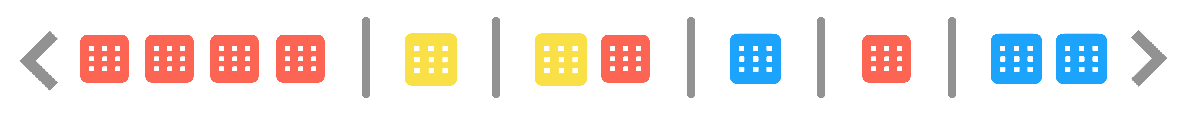

In [72]:
# show real sequence
show_restored_catalog(single_x, single_y, config, img_path_map)

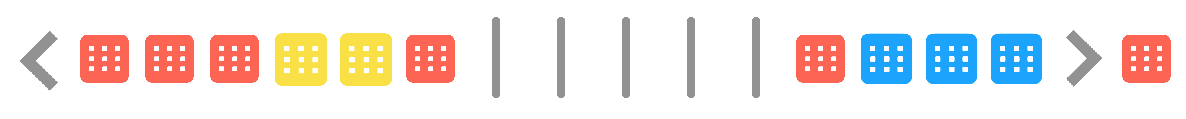

In [73]:
# predict & show
_, single_pred = model_ptrnet(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)

In [74]:
print(restore_catalog(single_x, single_pred[0]))

[5, 1, 1, 1, 2, 2, 1, 6, 6, 6, 6, 6, 1, 0, 0, 0, 7, 1]


### Predict all catalogs

In [75]:
# get predicted catalogs as indices
ptrnet_predicted_catalogs_as_indices = predict_catalogs_as_indices(test_dataloader, model_ptrnet)
print(ptrnet_predicted_catalogs_as_indices[0])

[5, 1, 1, 1, 2, 2, 2, 2, 6, 6, 6, 1, 0, 0, 0, 0, 0, 7]


In [76]:
# get them as raw
ptrnet_predicted_catalogs_as_raw = from_indices_to_raw(ptrnet_predicted_catalogs_as_indices, config)
print(ptrnet_predicted_catalogs_as_raw[0])

[['r', 'r', 'r', 'y', 'y', 'y', 'y'], [], [], ['r', 'b', 'b', 'b', 'b', 'b']]


In [77]:
# get them as Catalog() instances
ptrnet_predicted_catalogs_as_instances = instantiate_catalogs(ptrnet_predicted_catalogs_as_raw, config)
print(ptrnet_predicted_catalogs_as_instances[0].as_sequence())

['catalog_start', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'page_break', 'page_break', 'page_break', 'r', 'b', 'b', 'b', 'b', 'b', 'catalog_end']


### Metrics
We want to see how the predicted catalogs match up with the structural rules and the distributional stats of the original train set.

#### Structural Metrics

In [78]:
# get metrics for adherence to the rules
ptrnet_metrics = get_rule_metrics(ptrnet_predicted_catalogs_as_indices, rules, config)

# show metrics nicely
show_metrics(ptrnet_metrics)

*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       0.02%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      12.61%
           Valid section per ruleset % :
                                        basic      11.77%
                                   green_only      12.51%
                                  purple_only      18.09%
                             purple_and_green      12.28%

                             STRUCTURAL:
              Valid catalog structure %:        0.0%
            Valid catalog % per ruleset:
                                        basic        0.0%
                                   green_only        0.0%
                                  purple_only        0.0%
                             purple_and_green        0.0%
           Valid catalog % per sub rule:
       

#### Statistical / Distributional Metrics

In [79]:
ptrnet_stats = report_catalog_stats(ptrnet_predicted_catalogs_as_raw, config)

Total offer counts:  {'b': 4964, 'r': 8705, 'y': 4766, 'g': 1606, 'p': 915}
Total offer %:  {'b': 23.69, 'r': 41.54, 'y': 22.74, 'g': 7.66, 'p': 4.37}
Average offers per catalog: 11.21
Standard Dev offers per catalog: 0.46
Catalogs per num offers:  {13: 124, 11: 4079, 12: 797}
Catalogs per offer type:  {'b': 4964, 'r': 4951, 'y': 4759, 'g': 1606, 'p': 879}
Catalogs per offer type %:  {'b': 9.93, 'r': 9.9, 'y': 9.52, 'g': 3.21, 'p': 1.76, 'p_and_g': 0.558}
Catalogs per number of sections: {4: 150, 5: 1683, 6: 3167}
Catalogs per number of sections %: {4: 0.3, 5: 3.37, 6: 6.33}
Section count by number of offers: {0: 16186, 1: 1468, 2: 814, 3: 1027, 4: 1951, 5: 1870, 6: 1997, 7: 1442, 8: 801, 9: 383, 10: 75, 11: 3}
Section % by number of offers: {0: 57.77, 1: 5.24, 2: 2.91, 3: 3.67, 4: 6.96, 5: 6.67, 6: 7.13, 7: 5.15, 8: 2.86, 9: 1.37, 10: 0.27, 11: 0.01}


#### Sacred Experiment | Model PtrNet
We'll want to track the dataset, model params and the result of tests.

**Sacred will blow up if we give it a config consisting of nested dicts, so we'll need to turn things to list or str.**

In [80]:
# find nested dicts, show then, turn their values to strings, preserve them for later re-insertion
config_safe_copy = dict()
for k, v in config.items():
    if type(v) == dict:
        print(k)
        config_safe_copy[k] = str(v)
    else:
        config_safe_copy[k] = v

offer_distributions
word2idx
idx2word
rules


In [81]:
# experiment config
current_tested_model = model_ptrnet
current_optimizer = optimizer_ptrnet
current_last_loss = last_loss_ptrnet

config_update = {
    'model': current_tested_model.__class__.__name__,
    'final_training_loss': round(current_last_loss.item(), 10),
    'optimizer': current_optimizer.__class__.__name__,
    'cfg': config_safe_copy,
}

# run the experiment, with updated config
run_info = ex.run(config_updates=config_update)

WARNING - root - Changed type of config entry "cfg.offer_distributions" from dict to str
WARNING - root - Changed type of config entry "cfg.word2idx" from dict to str
WARNING - root - Changed type of config entry "cfg.idx2word" from dict to str
WARNING - root - Changed type of config entry "cfg.rules" from dict to str
INFO - set_to_sequence_functional_synthetic_mask_True - Running command 'run_model_tests'
INFO - set_to_sequence_functional_synthetic_mask_True - Started run with ID "86"


Model:  <class 'models.PointerNetwork'>
Result: 0.1853
*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       0.02%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      12.61%
           Valid section per ruleset % :
                                        basic      11.77%
                                   green_only      12.51%
                                  purple_only      18.09%
                             purple_and_green      12.28%

                             STRUCTURAL:
              Valid catalog structure %:        0.0%
            Valid catalog % per ruleset:
                                        basic        0.0%
                                   green_only        0.0%
                                  purple_only        0.0%
                             purple_and_green      

INFO - set_to_sequence_functional_synthetic_mask_True - Result: 0.18526
INFO - set_to_sequence_functional_synthetic_mask_True - Completed after 0:01:09


S-Rho: 0.5056, perc_valid: 100.0


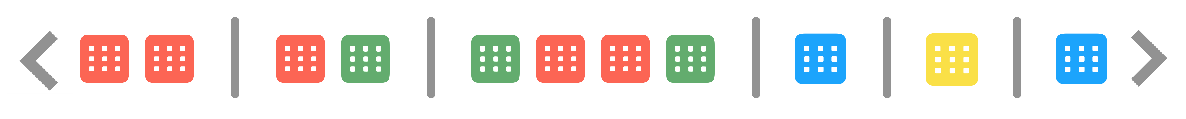

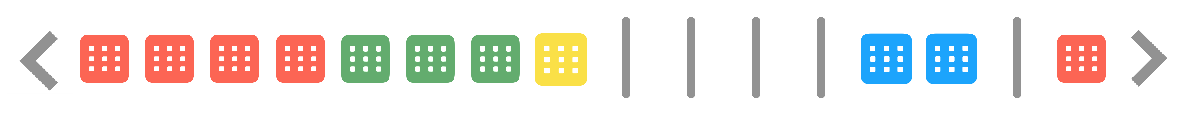

In [82]:
# show preds
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)
show_restored_catalog(single_x, single_y, config, img_path_map)
_, single_pred = model_ptrnet(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)

### DeepSets + PtrNet
Let's use deep sets to concatenate the representation of the entire set with each element, and then do PtrNet on it.

In [83]:
from torch.nn import Parameter
from models import DeepSets, DeepSetsPointerNetwork

#### Initialize DeepSets+PtrNet model

In [84]:
# instantiate the model
model_deep_sets = DeepSetsPointerNetwork(
    elem_dims=config['ptr_elem_dim'],
    embedding_dim=config['ptr_emb_dim'],
    hidden_dim=config['ptr_hid_dim'],
    lstm_layers=config['ptr_lstm_lay'],
    dropout=config['ptr_dropout'],
    bidir=config['ptr_bidir'],
    masking=config['ptr_mask'],
    embedding_by_dict=True,
    embedding_by_dict_size=len(config['word2idx'])
)

model_deep_sets.float()

DeepSetsPointerNetwork(
  (embedding): Embedding(8, 128)
  (set_embedding): DeepSets(
    (encode): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=256, bias=True)
      (7): ReLU()
      (8): Linear(in_features=256, out_features=256, bias=True)
      (9): ReLU()
      (10): Linear(in_features=256, out_features=256, bias=True)
      (11): ReLU()
      (12): Linear(in_features=256, out_features=128, bias=True)
      (13): ReLU()
    )
    (out): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, 

In [85]:
count_params(model_deep_sets)

The model has 874,880 trainable parameters


In [86]:
# loss
CCE = torch.nn.CrossEntropyLoss()

In [87]:
# optimizer
optimizer_deep_sets = optim.Adam(
    filter(lambda p: p.requires_grad, model_deep_sets.parameters()),
    lr=config['learning_rate'])

In [88]:
# test untrained model
results_deep_sets, _ = test_model_custom(model_deep_sets, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_deep_sets))

Result: 0.0557


In [89]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_deep_sets, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_deep_sets, get_single_spearman_rho, print_every=999999)))

K-Tau: -0.0002, % valid: 100.0
S-Rho: 0.0009, % valid: 100.0


In [90]:
# train
last_loss_deep_sets = train_epochs(
    model_deep_sets,
    optimizer_deep_sets,
    CCE,
    train_dataloader,
    config['num_epochs'],
    allow_gpu=True,
    x_name=0,
    y_name=1)

CUDA available, using GPU:
Quadro P6000


Epoch 20 / 20: 100%|██████████| 625/625 [01:07<00:00,  9.25 batches/s, avg_loss=2.76643]


In [91]:
last_loss_deep_sets.item()

2.766432046890259

In [92]:
# test
model_deep_sets.eval()  # if we had dropout or batchnorm, we must do this

# actual metrics
results_deep_sets, _ = test_model_custom(model_deep_sets, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_deep_sets))

Result: 0.2069


In [93]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_deep_sets, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_deep_sets, get_single_spearman_rho, print_every=999999)))

K-Tau: 0.4067, % valid: 100.0
S-Rho: 0.5277, % valid: 100.0


In [94]:
# get x y
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)

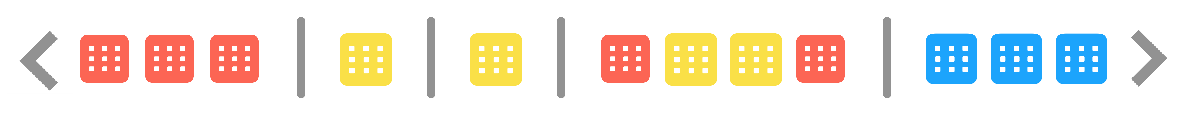

In [95]:
# show real sequence
show_restored_catalog(single_x, single_y, config, img_path_map)

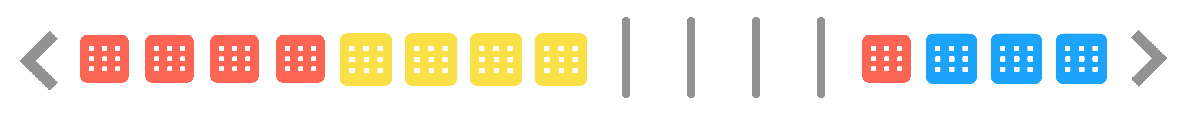

In [96]:
# predict & show
_, single_pred = model_deep_sets(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)

In [97]:
print(restore_catalog(single_x, single_pred[0]))

[5, 1, 1, 1, 1, 2, 2, 2, 2, 6, 6, 6, 6, 1, 0, 0, 0, 7]


### Predict all catalogs

In [98]:
# get predicted catalogs as indices
deep_sets_predicted_catalogs_as_indices = predict_catalogs_as_indices(test_dataloader, model_deep_sets)
print(deep_sets_predicted_catalogs_as_indices[0])

[5, 1, 1, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 0, 0, 0, 6, 7]


In [99]:
# get them as raw
deep_sets_predicted_catalogs_as_raw = from_indices_to_raw(deep_sets_predicted_catalogs_as_indices, config)
print(deep_sets_predicted_catalogs_as_raw[0])

[['r', 'r', 'y', 'y', 'y', 'y', 'y', 'y'], [], [], [], ['b', 'b', 'b']]


In [100]:
# get them as Catalog() instances
deep_sets_predicted_catalogs_as_instances = instantiate_catalogs(deep_sets_predicted_catalogs_as_raw, config)
print(deep_sets_predicted_catalogs_as_instances[0].as_sequence())

['catalog_start', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y', 'page_break', 'page_break', 'page_break', 'page_break', 'b', 'b', 'b', 'catalog_end']


### Metrics | Deep Sets
We want to see how the predicted catalogs match up with the structural rules and the distributional stats of the original train set.

#### Structural Metrics

In [101]:
# get metrics for adherence to the rules
deep_sets_metrics = get_rule_metrics(deep_sets_predicted_catalogs_as_indices, rules, config)

# show metrics nicely
show_metrics(deep_sets_metrics)

*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       0.62%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      19.06%
           Valid section per ruleset % :
                                        basic      15.73%
                                   green_only      24.47%
                                  purple_only      19.26%
                             purple_and_green      25.78%

                             STRUCTURAL:
              Valid catalog structure %:        4.0%
            Valid catalog % per ruleset:
                                        basic       7.16%
                                   green_only        0.0%
                                  purple_only        0.0%
                             purple_and_green        0.0%
           Valid catalog % per sub rule:
       

#### Statistical / Distributional Metrics

In [102]:
deep_sets_stats = report_catalog_stats(deep_sets_predicted_catalogs_as_raw, config)

Total offer counts:  {'b': 4964, 'r': 8730, 'y': 5262, 'g': 1609, 'p': 889}
Total offer %:  {'b': 23.14, 'r': 40.69, 'y': 24.53, 'g': 7.5, 'p': 4.14}
Average offers per catalog: 11.21
Standard Dev offers per catalog: 0.46
Catalogs per num offers:  {11: 4079, 12: 797, 13: 124}
Catalogs per offer type:  {'b': 4964, 'r': 4951, 'y': 4759, 'g': 1606, 'p': 879}
Catalogs per offer type %:  {'b': 9.93, 'r': 9.9, 'y': 9.52, 'g': 3.21, 'p': 1.76, 'p_and_g': 0.558}
Catalogs per number of sections: {4: 131, 5: 1502, 6: 3367}
Catalogs per number of sections %: {4: 0.26, 5: 3.0, 6: 6.73}
Section count by number of offers: {0: 15061, 1: 1374, 2: 1440, 3: 1929, 4: 3193, 5: 1806, 6: 1375, 7: 1018, 8: 636, 9: 311, 10: 84, 11: 9}
Section % by number of offers: {0: 53.34, 1: 4.87, 2: 5.1, 3: 6.83, 4: 11.31, 5: 6.4, 6: 4.87, 7: 3.61, 8: 2.25, 9: 1.1, 10: 0.3, 11: 0.03}


#### Sacred Experiment | Model DeepSets
We'll want to track the dataset, model params and the result of tests.

**Sacred will blow up if we give it a config consisting of nested dicts, so we'll need to turn things to list or str.**

In [103]:
# find nested dicts, show then, turn their values to strings, preserve them for later re-insertion
config_safe_copy = dict()
for k, v in config.items():
    if type(v) == dict:
        print(k)
        config_safe_copy[k] = str(v)
    else:
        config_safe_copy[k] = v

offer_distributions
word2idx
idx2word
rules


In [104]:
# experiment config
current_tested_model = model_deep_sets
current_optimizer = optimizer_deep_sets
current_last_loss = last_loss_deep_sets

config_update = {
    'model': current_tested_model.__class__.__name__,
    'final_training_loss': round(current_last_loss.item(), 10),
    'optimizer': current_optimizer.__class__.__name__,
    'cfg': config_safe_copy,
}

# run the experiment, with updated config
run_info = ex.run(config_updates=config_update)

WARNING - root - Changed type of config entry "cfg.offer_distributions" from dict to str
WARNING - root - Changed type of config entry "cfg.word2idx" from dict to str
WARNING - root - Changed type of config entry "cfg.idx2word" from dict to str
WARNING - root - Changed type of config entry "cfg.rules" from dict to str
INFO - set_to_sequence_functional_synthetic_mask_True - Running command 'run_model_tests'
INFO - set_to_sequence_functional_synthetic_mask_True - Started run with ID "87"


Model:  <class 'models.DeepSetsPointerNetwork'>
Result: 0.2069
*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       0.62%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      19.06%
           Valid section per ruleset % :
                                        basic      15.73%
                                   green_only      24.47%
                                  purple_only      19.26%
                             purple_and_green      25.78%

                             STRUCTURAL:
              Valid catalog structure %:        4.0%
            Valid catalog % per ruleset:
                                        basic       7.16%
                                   green_only        0.0%
                                  purple_only        0.0%
                             purple_and_gre

INFO - set_to_sequence_functional_synthetic_mask_True - Result: 0.20686
INFO - set_to_sequence_functional_synthetic_mask_True - Completed after 0:00:57


S-Rho: 0.5277, perc_valid: 100.0


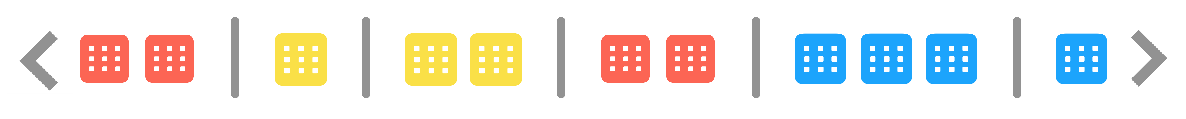

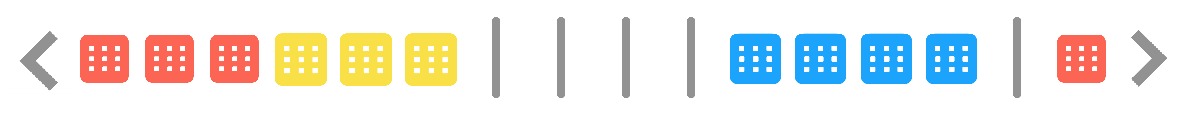

In [105]:
# show preds
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)
show_restored_catalog(single_x, single_y, config, img_path_map)
_, single_pred = model_deep_sets(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)

### Set Transformer + PtrNet
Let's use deep sets to concatenate the representation of the entire set with each element, and then do PtrNet on it.

In [106]:
from models import SetTransformer, SetTransformerPointerNetwork

#### Initialize Set Transformer + PtrNet model

In [107]:
# instantiate the model
model_set_trans = SetTransformerPointerNetwork(
    elem_dims=config['ptr_elem_dim'],
    embedding_dim=config['ptr_emb_dim'],
    hidden_dim=config['ptr_hid_dim'],
    lstm_layers=config['ptr_lstm_lay'],
    dropout=config['ptr_dropout'],
    bidir=config['ptr_bidir'],
    masking=config['ptr_mask'],
    embedding_by_dict=True,
    embedding_by_dict_size=len(config['word2idx'])
)

# NEED TO TURN BOTH MODEL AND INPUT DATA TO EITHER .float() or .double() for 32 or 64 bit precision
model_set_trans.float()

SetTransformerPointerNetwork(
  (embedding): Embedding(8, 128)
  (set_embedding): SetTransformer(
    (emb): Sequential(
      (0): SAB(
        (mab): MAB(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (1): SAB(
        (mab): MAB(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
        )
      )
    )
    (enc): Sequential(
      (0): PMA(
        (mab): MAB(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=Tr

In [108]:
count_params(model_set_trans)

The model has 875,776 trainable parameters


In [109]:
# loss
CCE = torch.nn.CrossEntropyLoss()

In [110]:
# optimizer
optimizer_set_trans = optim.Adam(
    filter(lambda p: p.requires_grad, model_set_trans.parameters()),
    lr=config['learning_rate'])

In [111]:
# test untrained model
results_set_trans, _ = test_model_custom(model_set_trans, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_set_trans))

Result: 0.0475


In [112]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_set_trans, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_set_trans, get_single_spearman_rho, print_every=999999)))

K-Tau: -0.0976, % valid: 100.0
S-Rho: -0.1399, % valid: 100.0


In [113]:
# train
last_loss_set_trans = train_epochs(
    model_set_trans,
    optimizer_set_trans,
    CCE,
    train_dataloader,
    config['num_epochs'],
    allow_gpu=True,
    x_name=0,
    y_name=1)

CUDA available, using GPU:
Quadro P6000


Epoch 20 / 20: 100%|██████████| 625/625 [01:16<00:00,  8.20 batches/s, avg_loss=2.76080]


In [114]:
last_loss_set_trans.item()

2.7607996463775635

In [115]:
# test
model_set_trans.eval()  # if we had dropout or batchnorm, we must do this

# actual metrics
results_set_trans, _ = test_model_custom(model_set_trans, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_set_trans))

Result: 0.2007


In [116]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_set_trans, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_set_trans, get_single_spearman_rho, print_every=999999)))

K-Tau: 0.3937, % valid: 100.0
S-Rho: 0.5107, % valid: 100.0


In [117]:
# get x y
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)

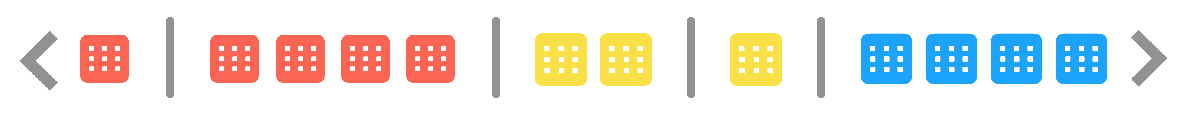

In [118]:
# show real sequence
show_restored_catalog(single_x, single_y, config, img_path_map)

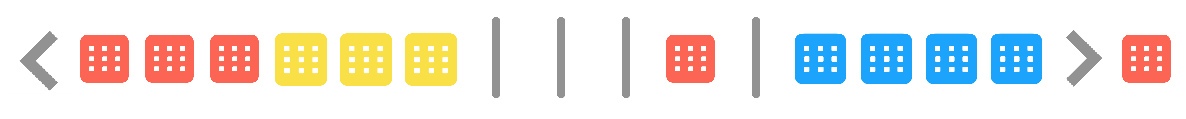

In [119]:
# predict & show
_, single_pred = model_set_trans(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)

In [120]:
print(restore_catalog(single_x, single_pred[0]))

[5, 1, 1, 1, 2, 2, 2, 6, 6, 6, 1, 6, 0, 0, 0, 0, 7, 1]


#### Predict all catalogs

In [121]:
# get predicted catalogs as indices
set_trans_predicted_catalogs_as_indices = predict_catalogs_as_indices(test_dataloader, model_set_trans)
print(set_trans_predicted_catalogs_as_indices[0])

[5, 1, 1, 1, 2, 2, 2, 6, 6, 6, 6, 6, 1, 0, 0, 0, 7, 1]


In [122]:
# get them as raw
set_trans_predicted_catalogs_as_raw = from_indices_to_raw(set_trans_predicted_catalogs_as_indices, config)
print(set_trans_predicted_catalogs_as_raw[0])

[['r', 'r', 'r', 'y', 'y', 'y'], [], [], [], [], ['r', 'b', 'b', 'b', 'r']]


In [123]:
# get them as Catalog() instances
set_trans_predicted_catalogs_as_instances = instantiate_catalogs(set_trans_predicted_catalogs_as_raw, config)
print(set_trans_predicted_catalogs_as_instances[0].as_sequence())

['catalog_start', 'r', 'r', 'r', 'y', 'y', 'y', 'page_break', 'page_break', 'page_break', 'page_break', 'page_break', 'r', 'b', 'b', 'b', 'r', 'catalog_end']


### Metrics | Set Transformer
We want to see how the predicted catalogs match up with the structural rules and the distributional stats of the original train set.

#### Structural Metrics

In [124]:
# get metrics for adherence to the rules
set_trans_metrics = get_rule_metrics(set_trans_predicted_catalogs_as_indices, rules, config)

# show metrics nicely
show_metrics(set_trans_metrics)

*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       3.46%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      28.22%
           Valid section per ruleset % :
                                        basic      18.89%
                                   green_only      42.21%
                                  purple_only      30.67%
                             purple_and_green      37.19%

                             STRUCTURAL:
              Valid catalog structure %:       10.0%
            Valid catalog % per ruleset:
                                        basic      10.81%
                                   green_only       8.52%
                                  purple_only        0.0%
                             purple_and_green      30.47%
           Valid catalog % per sub rule:
       

#### Statistical / Distributional Metrics

In [125]:
set_trans_stats = report_catalog_stats(set_trans_predicted_catalogs_as_raw, config)

Total offer counts:  {'b': 5130, 'r': 8514, 'y': 5734, 'g': 1626, 'p': 879}
Total offer %:  {'b': 23.44, 'r': 38.91, 'y': 26.2, 'g': 7.43, 'p': 4.02}
Average offers per catalog: 11.21
Standard Dev offers per catalog: 0.46
Catalogs per num offers:  {11: 4079, 12: 797, 13: 124}
Catalogs per offer type:  {'b': 4964, 'r': 4951, 'y': 4759, 'g': 1606, 'p': 879}
Catalogs per offer type %:  {'b': 9.93, 'r': 9.9, 'y': 9.52, 'g': 3.21, 'p': 1.76, 'p_and_g': 0.558}
Catalogs per number of sections: {3: 16, 4: 186, 5: 1446, 6: 3352}
Catalogs per number of sections %: {3: 0.03, 4: 0.37, 5: 2.89, 6: 6.7}
Section count by number of offers: {0: 12549, 1: 3920, 2: 2100, 3: 1822, 4: 2278, 5: 2050, 6: 1772, 7: 921, 8: 505, 9: 192, 10: 25}
Section % by number of offers: {0: 44.6, 1: 13.93, 2: 7.46, 3: 6.48, 4: 8.1, 5: 7.29, 6: 6.3, 7: 3.27, 8: 1.79, 9: 0.68, 10: 0.09}


#### Sacred Experiment | Model SetTrans
We'll want to track the dataset, model params and the result of tests.

**Sacred will blow up if we give it a config consisting of nested dicts, so we'll need to turn things to list or str.**

In [126]:
# find nested dicts, show then, turn their values to strings, preserve them for later re-insertion
config_safe_copy = dict()
for k, v in config.items():
    if type(v) == dict:
        print(k)
        config_safe_copy[k] = str(v)
    else:
        config_safe_copy[k] = v

offer_distributions
word2idx
idx2word
rules


In [127]:
# experiment config
current_tested_model = model_set_trans
current_optimizer = optimizer_set_trans
current_last_loss = last_loss_set_trans

config_update = {
    'model': current_tested_model.__class__.__name__,
    'final_training_loss': round(current_last_loss.item(), 10),
    'optimizer': current_optimizer.__class__.__name__,
    'cfg': config_safe_copy,
}

# run the experiment, with updated config
run_info = ex.run(config_updates=config_update)

WARNING - root - Changed type of config entry "cfg.offer_distributions" from dict to str
WARNING - root - Changed type of config entry "cfg.word2idx" from dict to str
WARNING - root - Changed type of config entry "cfg.idx2word" from dict to str
WARNING - root - Changed type of config entry "cfg.rules" from dict to str
INFO - set_to_sequence_functional_synthetic_mask_True - Running command 'run_model_tests'
INFO - set_to_sequence_functional_synthetic_mask_True - Started run with ID "88"


Model:  <class 'models.SetTransformerPointerNetwork'>
Result: 0.2007
*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       3.46%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      28.22%
           Valid section per ruleset % :
                                        basic      18.89%
                                   green_only      42.21%
                                  purple_only      30.67%
                             purple_and_green      37.19%

                             STRUCTURAL:
              Valid catalog structure %:       10.0%
            Valid catalog % per ruleset:
                                        basic      10.81%
                                   green_only       8.52%
                                  purple_only        0.0%
                             purple_a

INFO - set_to_sequence_functional_synthetic_mask_True - Result: 0.20069
INFO - set_to_sequence_functional_synthetic_mask_True - Completed after 0:01:02


S-Rho: 0.5107, perc_valid: 100.0


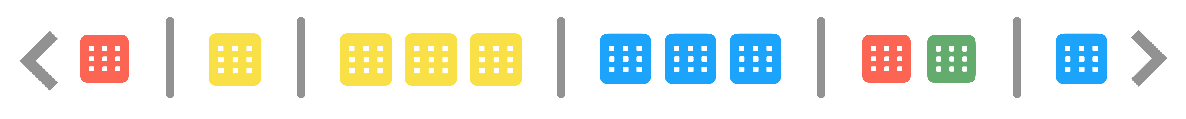

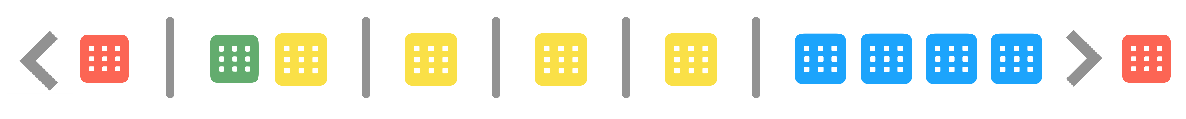

In [128]:
# show preds
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)
show_restored_catalog(single_x, single_y, config, img_path_map)
_, single_pred = model_set_trans(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)

### Custom Set Embedder + PtrNet
Let's use deep sets to concatenate the representation of the entire set with each element, and then do PtrNet on it.

In [129]:
from models import CustomAttentionSetEmbedder, CustomAttentionPointerNetwork

#### Initialize Set Transformer + PtrNet model

In [130]:
# instantiate the model
model_custom = CustomAttentionPointerNetwork(
    elem_dims=config['ptr_elem_dim'],
    embedding_dim=config['ptr_emb_dim'],
    hidden_dim=config['ptr_hid_dim'],
    lstm_layers=config['ptr_lstm_lay'],
    dropout=config['ptr_dropout'],
    bidir=config['ptr_bidir'],
    masking=config['ptr_mask'],
    embedding_by_dict=True,
    embedding_by_dict_size=len(config['word2idx'])
)

# NEED TO TURN BOTH MODEL AND INPUT DATA TO EITHER .float() or .double() for 32 or 64 bit precision
model_custom.float()

CustomAttentionPointerNetwork(
  (embedding): Embedding(8, 128)
  (set_embedding): CustomAttentionSetEmbedder(
    (l1): CustomAttentionSetLayer(
      (e): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
      )
      (s): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=1, bias=True)
        (3): ReLU()
      )
      (a): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
      )
    )
    (l2): CustomAttentionSetLayer(
      (e): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
      )
   

In [131]:
count_params(model_custom)

The model has 694,274 trainable parameters


In [132]:
# loss
CCE = torch.nn.CrossEntropyLoss()

In [133]:
# optimizer
optimizer_custom = optim.Adam(
    filter(lambda p: p.requires_grad, model_custom.parameters()),
    lr=config['learning_rate'])

In [134]:
# test untrained model
results_custom, _ = test_model_custom(model_custom, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_custom))

Result: 0.0539


In [135]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_custom, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_custom, get_single_spearman_rho, print_every=999999)))

K-Tau: 0.0031, % valid: 100.0
S-Rho: 0.0033, % valid: 100.0


In [136]:
# train
last_loss_custom = train_epochs(
    model_custom,
    optimizer_custom,
    CCE,
    train_dataloader,
    config['num_epochs'],
    allow_gpu=True,
    x_name=0,
    y_name=1)

CUDA available, using GPU:
Quadro P6000


Epoch 20 / 20: 100%|██████████| 625/625 [01:29<00:00,  6.96 batches/s, avg_loss=2.76352]


In [137]:
last_loss_custom.item()

2.7635226249694824

In [138]:
# test
model_custom.eval()  # if we had dropout or batchnorm, we must do this

# actual metrics
results_custom, _ = test_model_custom(model_custom, test_dataloader, compare_solved_sort_unique, print_every=999999, x_name=0, y_name=1)
print('Result: {:.4f}'.format(results_custom))

Result: 0.1792


In [139]:
# show rank correlations only with mask on
print('K-Tau: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_custom, get_single_kendall_tau, print_every=999999)))
print('S-Rho: {:.4f}, % valid: {}'.format(*get_batch_rank_correlation_and_perc_valid(test_dataloader, model_custom, get_single_spearman_rho, print_every=999999)))

K-Tau: 0.3771, % valid: 100.0
S-Rho: 0.4851, % valid: 100.0


In [140]:
# get x y
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)

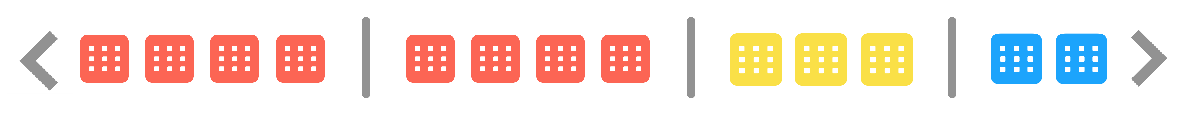

In [141]:
# show real sequence
show_restored_catalog(single_x, single_y, config, img_path_map)

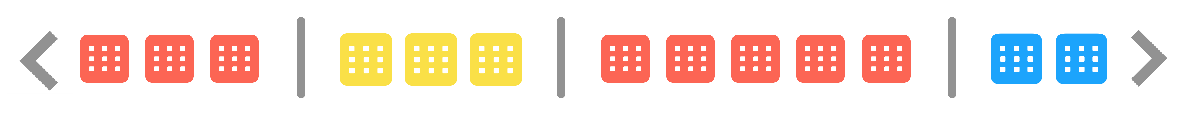

In [142]:
# predict & show
_, single_pred = model_custom(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)

In [143]:
print(restore_catalog(single_x, single_pred[0]))

[5, 1, 1, 1, 6, 2, 2, 2, 6, 1, 1, 1, 1, 1, 6, 0, 0, 7]


#### Predict all catalogs

In [144]:
# get predicted catalogs as indices
custom_predicted_catalogs_as_indices = predict_catalogs_as_indices(test_dataloader, model_custom)
print(custom_predicted_catalogs_as_indices[0])

[5, 1, 1, 2, 2, 2, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 6, 7]


In [145]:
# get them as raw
custom_predicted_catalogs_as_raw = from_indices_to_raw(custom_predicted_catalogs_as_indices, config)
print(custom_predicted_catalogs_as_raw[0])

[['r', 'r', 'y', 'y', 'y'], [], [], [], ['b', 'b', 'b', 'b', 'b', 'b']]


In [146]:
# get them as Catalog() instances
custom_predicted_catalogs_as_instances = instantiate_catalogs(custom_predicted_catalogs_as_raw, config)
print(custom_predicted_catalogs_as_instances[0].as_sequence())

['catalog_start', 'r', 'r', 'y', 'y', 'y', 'page_break', 'page_break', 'page_break', 'page_break', 'b', 'b', 'b', 'b', 'b', 'b', 'catalog_end']


### Metrics | Custom Set Embedder
We want to see how the predicted catalogs match up with the structural rules and the distributional stats of the original train set.

#### Structural Metrics

In [147]:
# get metrics for adherence to the rules
custom_metrics = get_rule_metrics(custom_predicted_catalogs_as_indices, rules, config)

# show metrics nicely
show_metrics(custom_metrics)

*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       0.12%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      14.66%
           Valid section per ruleset % :
                                        basic       8.64%
                                   green_only      10.61%
                                  purple_only      47.42%
                             purple_and_green      20.18%

                             STRUCTURAL:
              Valid catalog structure %:       1.72%
            Valid catalog % per ruleset:
                                        basic       3.08%
                                   green_only        0.0%
                                  purple_only        0.0%
                             purple_and_green        0.0%
           Valid catalog % per sub rule:
       

#### Statistical / Distributional Metrics

In [148]:
custom_stats = report_catalog_stats(custom_predicted_catalogs_as_raw, config)

Total offer counts:  {'b': 4999, 'r': 9086, 'y': 4759, 'g': 1606, 'p': 879}
Total offer %:  {'b': 23.44, 'r': 42.6, 'y': 22.31, 'g': 7.53, 'p': 4.12}
Average offers per catalog: 11.21
Standard Dev offers per catalog: 0.46
Catalogs per num offers:  {11: 4079, 12: 797, 13: 124}
Catalogs per offer type:  {'b': 4964, 'r': 4951, 'y': 4759, 'g': 1606, 'p': 879}
Catalogs per offer type %:  {'b': 9.93, 'r': 9.9, 'y': 9.52, 'g': 3.21, 'p': 1.76, 'p_and_g': 0.558}
Catalogs per number of sections: {4: 135, 5: 1079, 6: 3786}
Catalogs per number of sections %: {4: 0.27, 5: 2.16, 6: 7.57}
Section count by number of offers: {0: 15976, 1: 2115, 2: 854, 3: 1150, 4: 1851, 5: 2359, 6: 2034, 7: 1412, 8: 647, 9: 222, 10: 30, 11: 1}
Section % by number of offers: {0: 55.76, 1: 7.38, 2: 2.98, 3: 4.01, 4: 6.46, 5: 8.23, 6: 7.1, 7: 4.93, 8: 2.26, 9: 0.77, 10: 0.1, 11: 0.0}


#### Sacred Experiment | Model Custom
We'll want to track the dataset, model params and the result of tests.

**Sacred will blow up if we give it a config consisting of nested dicts, so we'll need to turn things to list or str.**

In [149]:
# find nested dicts, show then, turn their values to strings, preserve them for later re-insertion
config_safe_copy = dict()
for k, v in config.items():
    if type(v) == dict:
        print(k)
        config_safe_copy[k] = str(v)
    else:
        config_safe_copy[k] = v

offer_distributions
word2idx
idx2word
rules


In [150]:
# experiment config
current_tested_model = model_custom
current_optimizer = optimizer_custom
current_last_loss = last_loss_custom

config_update = {
    'model': current_tested_model.__class__.__name__,
    'final_training_loss': round(current_last_loss.item(), 10),
    'optimizer': current_optimizer.__class__.__name__,
    'cfg': config_safe_copy,
}

# run the experiment, with updated config
run_info = ex.run(config_updates=config_update)

WARNING - root - Changed type of config entry "cfg.offer_distributions" from dict to str
WARNING - root - Changed type of config entry "cfg.word2idx" from dict to str
WARNING - root - Changed type of config entry "cfg.idx2word" from dict to str
WARNING - root - Changed type of config entry "cfg.rules" from dict to str
INFO - set_to_sequence_functional_synthetic_mask_True - Running command 'run_model_tests'
INFO - set_to_sequence_functional_synthetic_mask_True - Started run with ID "89"


Model:  <class 'models.CustomAttentionPointerNetwork'>
Result: 0.1792
*** METRICS ***
                                GENERAL:
              Total testable catalogs %:       0.12%
       Catalogs with corrent n tokens %:      100.0%
      Catalogs with target num offers %:      15.94%

                               SECTIONS:
                Valid section average %:      14.66%
           Valid section per ruleset % :
                                        basic       8.64%
                                   green_only      10.61%
                                  purple_only      47.42%
                             purple_and_green      20.18%

                             STRUCTURAL:
              Valid catalog structure %:       1.72%
            Valid catalog % per ruleset:
                                        basic       3.08%
                                   green_only        0.0%
                                  purple_only        0.0%
                             purple_

INFO - set_to_sequence_functional_synthetic_mask_True - Result: 0.17919
INFO - set_to_sequence_functional_synthetic_mask_True - Completed after 0:01:03


S-Rho: 0.4851, perc_valid: 100.0


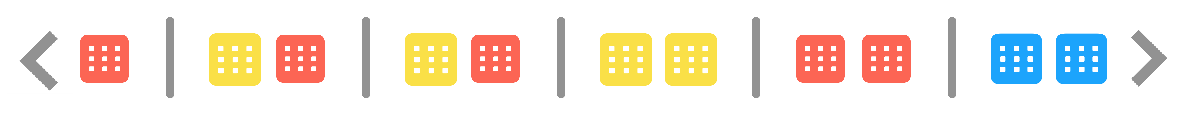

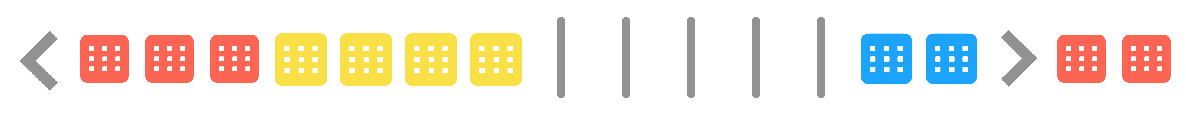

In [151]:
# show preds
single_x, single_y = get_example(test_dataloader, x_name=0, y_name=1)
show_restored_catalog(single_x, single_y, config, img_path_map)
_, single_pred = model_custom(single_x.unsqueeze(0))
show_restored_catalog(single_x, single_pred, config, img_path_map)